# Computer Class 2 - polynomial regression, cross-validation, PCA, k-nearest neighbors regression, kernel regression and scikit-learn

The examples and exercises in this computer class introduce the student to polynomial regression, cross-validation, PCA, k-nearest neighbors regression, kernel regression and the use of the scikit-learn package for training and evaluating models. This computer class can be used in conjunction with chapters 1-3 of the reader.

*Authors: Cees Diks and Bram Wouters, Faculty Economics and Business, University of Amsterdam (UvA)* <br>
*Copyright (C): UvA (2024)* <br>
*Credits: some of the examples and formulations are taken from Hastie et al. (2009)*

In [333]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
np.random.seed(53)

# Part 1: polynomial regression 

## Data generation

Most of this notebook focuses on a regression problem with one explanatory variable and a linear model with polynomial basis functions. In the cells below, we generate a data set of size $N=20.$ The data of the explanatory variable are fixed to equidistant points on the interval $[0,1]$. The dependent variable is chosen to be a sinusoid plus Gaussian noise.

We will use the conventions of the scikit-learn package to store data in Python objects. Features are stored in a 2-dimensional NumPy ndarray and bound to the variable `X`. This array has dimensions $N \times p$ in the case of input features, and $N \times (M+1)$ or $N \times M$ in the case of derived features. Whether the bias is included in `X` as a column of ones depends on the context. The target variable is denoted by `y` and is a 1-dimensional NumPy array.

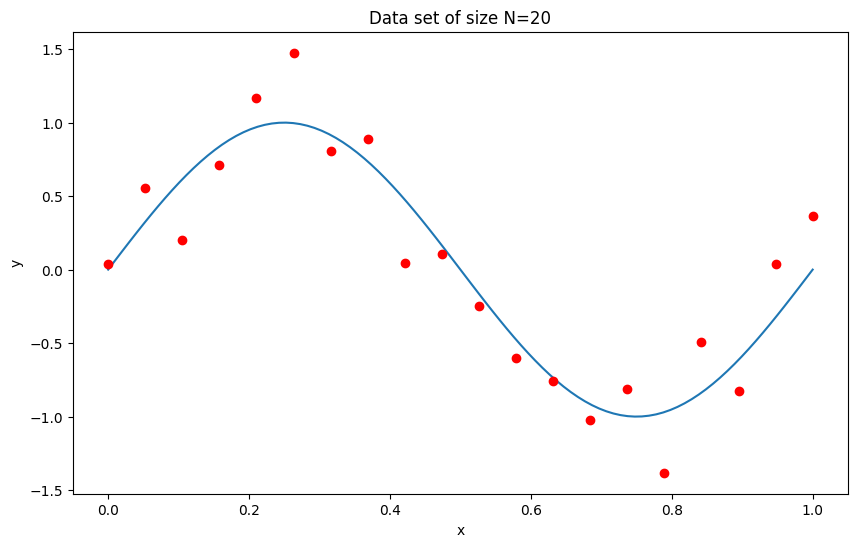

In [334]:
N = 20
sigma = 0.2

def f(x): return np.sin(2*np.pi*x) # The sinusoidal function underlying the data-generating process

X = np.linspace(0, 1, N).reshape(N,1) # Features are stored in a 2-dimensional ndarray
eps = np.random.normal(0, sigma, N)
y = f(X.reshape(N)) + eps # The target variable is stored in a 1-dimensional ndarray

# Plotting the datapoints and the underlying model:
fig1 = plt.figure(1, figsize=(10,6))
ax = fig1.add_subplot(1,1,1)

x_range = np.linspace(0,1,100)
ax.plot(x_range, f(x_range)) # Plotting the sinusoid
ax.plot(X, y, 'o', color='red') # Plotting the data points

ax.set_title('Data set of size N={}'.format(N))

ax.set_xlabel('x')
ax.set_ylabel('y');

In [335]:
print("Features are stored in a 2-dimensional ndarray: \n {} \n".format(X))

print("The target variable is stored in a 1-dimensional ndarray \n {} \n".format(y))

Features are stored in a 2-dimensional ndarray: 
 [[0.        ]
 [0.05263158]
 [0.10526316]
 [0.15789474]
 [0.21052632]
 [0.26315789]
 [0.31578947]
 [0.36842105]
 [0.42105263]
 [0.47368421]
 [0.52631579]
 [0.57894737]
 [0.63157895]
 [0.68421053]
 [0.73684211]
 [0.78947368]
 [0.84210526]
 [0.89473684]
 [0.94736842]
 [1.        ]] 

The target variable is stored in a 1-dimensional ndarray 
 [ 0.04117297  0.55805181  0.19968476  0.71062904  1.16882556  1.47549525
  0.80752659  0.88626499  0.04587703  0.10350648 -0.24497379 -0.59835392
 -0.76040567 -1.02139741 -0.81435439 -1.38177801 -0.49034798 -0.82544884
  0.03650537  0.3678851 ] 



## Linear model with polynomial basis functions

In this section we are training a linear model with polynomial basis functions.

**Example:** the function `polynomial_features` generates the derived features, which in this case are the powers up to a degree M of the original input variable. Note that (by default) we are including a column of ones, representing the bias of the linear model, but you can also leave out this column.

In [336]:
def polynomial_features(X, M, bias=True):
    if bias:
        return np.concatenate(tuple([X**n for n in range(M+1)]), axis=1)
    if not bias:
        return np.concatenate(tuple([X**n for n in range(1, M+1)]), axis=1)

polynomial_features(X, 3)

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 5.26315789e-02, 2.77008310e-03, 1.45793847e-04],
       [1.00000000e+00, 1.05263158e-01, 1.10803324e-02, 1.16635078e-03],
       [1.00000000e+00, 1.57894737e-01, 2.49307479e-02, 3.93643388e-03],
       [1.00000000e+00, 2.10526316e-01, 4.43213296e-02, 9.33080624e-03],
       [1.00000000e+00, 2.63157895e-01, 6.92520776e-02, 1.82242309e-02],
       [1.00000000e+00, 3.15789474e-01, 9.97229917e-02, 3.14914711e-02],
       [1.00000000e+00, 3.68421053e-01, 1.35734072e-01, 5.00072897e-02],
       [1.00000000e+00, 4.21052632e-01, 1.77285319e-01, 7.46464499e-02],
       [1.00000000e+00, 4.73684211e-01, 2.24376731e-01, 1.06283715e-01],
       [1.00000000e+00, 5.26315789e-01, 2.77008310e-01, 1.45793847e-01],
       [1.00000000e+00, 5.78947368e-01, 3.35180055e-01, 1.94051611e-01],
       [1.00000000e+00, 6.31578947e-01, 3.98891967e-01, 2.51931768e-01],
       [1.00000000e+00, 6.84210526e-01, 4.68144044e

**Example:** the function `get_parameters_lin_mod` computes the parameters ($\beta$) of the OLS solution of the linear model, using as input arguments the derived features and the target variable. We are using the `pinv` function of NumPy to compute the pseudoinverse.

In [337]:
def get_parameters_lin_mod(X, y):
    return np.linalg.pinv(X) @ y

**Example:** the function `train_lin_mod` returns a function that is fitted on the derived features and target variable, which it takes as input arguments. The returned function can act on 2-dimensional NumPy arrays like `X` and returns predictions for the target variable in the form of a 1-dimensional NumPy array.

In [338]:
def train_lin_mod(X, y):
    
    parameters = get_parameters_lin_mod(X, y)
    
    def fhat(X_new): return X_new @ parameters
    
    return fhat     

**Example:** below, we are plotting the OLS solutions for $M = 2, 5, 15,$ supplemented by the data-generating sinusoid and the $N$ datapoints.

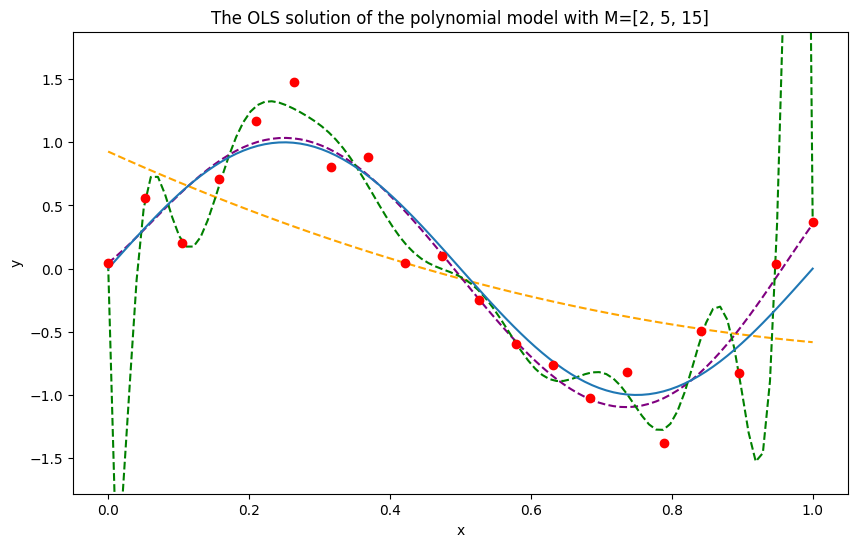

In [339]:
degrees_for_plotting = [(2, 'orange'), (5, 'purple'), (15, 'green')]

# Creating the figure    
fig2 = plt.figure(figsize=(10,6));
ax = fig2.add_subplot(1,1,1)

x_range = np.linspace(0, 1, 100)

for M, color in degrees_for_plotting:
    
    X_derived = polynomial_features(X, M)
    model = train_lin_mod(X_derived, y)
    
    x_range_polynomial = polynomial_features(x_range.reshape(-1, 1), M)
    ax.plot(x_range, model(x_range_polynomial), ls='--', color=color)
    
ax.plot(x_range, f(x_range));
ax.plot(X, y, 'o', color='red')

ax.set_title('The OLS solution of the polynomial model with M={}'.format([M for M, color in degrees_for_plotting]))
ax.set_ylim(min(y)-0.4,max(y)+0.4)
ax.set_xlabel('x')
ax.set_ylabel('y');

# Part 2: cross-validation

In this chapter, you will write your own implementation of $K$-fold cross-validation and use it to determine an optimal value for $M$ in the case of the polynomial model.

**Example:** given $N$ and $K,$ the function `generate_CV_test_indices` returns a list of $K$ arrays, each array representing the indices of the **test set** of a fold. As an example, we are printing the output for the case $N=20$ and $K=6.$ Note that the split of indices over the folds is random.

In [340]:
def generate_CV_test_indices(N, K):
    
    ints = np.random.permutation(np.arange(N))
        
    short_length = N // K
    number_long_folds = N % K
    
    long_folds = ints[:number_long_folds*(short_length + 1)].reshape(number_long_folds, short_length + 1)
    short_folds = ints[number_long_folds*(short_length + 1):].reshape(K - number_long_folds, short_length)
    
    return list(long_folds) + list(short_folds)

generate_CV_test_indices(20,6)

[array([ 8,  2, 19,  1]),
 array([11, 18,  4, 13]),
 array([15,  6,  9]),
 array([ 7, 17, 14]),
 array([16, 10,  5]),
 array([ 0, 12,  3])]

**Exercise 1:** write a function `CV_RMSE` that uses $K$-fold cross-validation to estimate the root-mean-square error of a polynomial model of degree $M$ that is fitted with `train_lin_mod`. 

The function should have four arguments: a 2-dimensional array of input (`X`), a 1-dimensional array of the target variable (`y_target`), the maximum degree of the polynomial functions (`M`) and an integer `K` corresponding to the $K$ in $K$-fold cross-validation. 

The function should return a 2-tuple. The first element of the tuple is the estimate of the RMSE. The second element of the tuple is the "standard error" of the estimate, which is the standard deviation of the sample mean. The sample of RMSE estimates has size $K,$ corresponding to the number of folds. You may assume they are independent and identically distributed. 

In order to help you, the first part of the function is already worked out in the cell below. The `#...` represent places where one (**or more than one**) line of code is missing. You are required to fill in the missing code. Finally, you can test your code by running the function at the bottom of the cell. (Hint: to calculate the sample standard deviation, one can use the NumPy function `std` with one degree of freedom (`ddof`) less.)

In [341]:
from sklearn.metrics import root_mean_squared_error # type: ignore

def CV_RMSE(X, y, M, K):
    
    N = len(y)      # determine the size of the dataset
    X_derived = polynomial_features(X, M)      # computing the derived features
    CVk = np.array([])      # An empty array, to be filled with the errors computed on the K different folds.
                            # Corresponds to eq. 1.17 of the reader.
    
    for test_indices in generate_CV_test_indices(N, K):
        
        X_training, X_test = np.delete(X_derived, test_indices, axis=0), X_derived[test_indices]
        y_training, y_test = np.delete(y, test_indices), y[test_indices]
        f_hat = train_lin_mod(X_training, y_training)
        y_hat = f_hat(X_test)
        rmse = root_mean_squared_error(y_test, y_hat)
        CVk = np.append(CVk, rmse)
        
    
        
    return (CVk.mean(), CVk.std(ddof=1))

CV_RMSE(X, y, 3, 5)


(np.float64(0.28699569166574623), np.float64(0.10071665759593092))

**Exercise 2:** plot the RMSE estimates, including the standard errors using error bars, as a function of $M.$ Use $5$-fold cross-validation. Take the range of $M$ large enough to see the effect of a large bias (low model complexity/underfitting) as well as the effect a large variance (high model complexity/overfitting).

<ErrorbarContainer object of 3 artists>

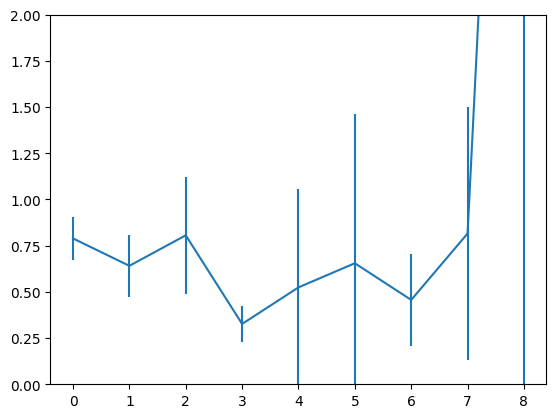

In [342]:
m = np.arange(0, 9)
y_rmse = list()
y_std = list()
for M in m:
    mean, std = CV_RMSE(X, y, M, 5)
    y_rmse.append(mean)
    y_std.append(std)

plt.ylim(0., 2)
plt.errorbar(m, y_rmse, yerr=y_std)

**Exercise 3:** use the one-standard-error rule and the plot of the previous exercise to identify an optimal value of $M$.

#### ANSWER IN PLAIN TEXT: ####
The lowest `RMSE` is at `M=3`, and within 1 std error the least complex model with a `RMSE` within that error is `M=3`


# Part 3: introduction to Scikit-learn

The scikit-learn package is arguably the most widely used general-purpose machine learning toolkit currently being used by Python programmers. It provides algorithms for most standard learning techniques (both supervised and unsupervised), as well as model evaluation/selection procedures. In this chapter, you will be introduced to the basic syntax and functionality of scikit-learn in the context of the linear model with polynomial basis functions.

**Example:** the `linear_model` module of scikit-learn provides all the linear-model learning techniques we are currently interested in, namely basic OLS, ridge regression and lasso. In order to keep the code tidy, one often imports specific learning techniques explicitely. In the cell below, this is done for the OLS solution to the linear model (`LinearRegression`).

In [343]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

**Example:** unfortunately, pandas objects (e.g. DataFrames) are not nicely integrated in the current version of scikit-learn. Instead, scikit-learn works with NumPy ndarrays. The format of the input data is always a 2-dimensional array (often denoted by X), whose rows are the data points and whose columns are the (derived) features.

In the case of a linear model with polynomial basis functions, the derived features are the powers of the input variable. They can be generated using the function `PolynomialFeatures`. Note that we do not include a zeroth power, corresponding to the intercept parameter of the model. That is because scikit-learn computes the intercept of linear-model techniques separately from the other parameters (as we will see shortly).

In [344]:
from sklearn.preprocessing import PolynomialFeatures

In [345]:
M = 4

poly = PolynomialFeatures(degree=M, include_bias=False)
X_derived = poly.fit_transform(X) # Creating the derived features

print('The format of the (derived) features is a 2-dimensional numpy array:')
X_derived

The format of the (derived) features is a 2-dimensional numpy array:


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.26315789e-02, 2.77008310e-03, 1.45793847e-04, 7.67336039e-06],
       [1.05263158e-01, 1.10803324e-02, 1.16635078e-03, 1.22773766e-04],
       [1.57894737e-01, 2.49307479e-02, 3.93643388e-03, 6.21542192e-04],
       [2.10526316e-01, 4.43213296e-02, 9.33080624e-03, 1.96438026e-03],
       [2.63157895e-01, 6.92520776e-02, 1.82242309e-02, 4.79585025e-03],
       [3.15789474e-01, 9.97229917e-02, 3.14914711e-02, 9.94467507e-03],
       [3.68421053e-01, 1.35734072e-01, 5.00072897e-02, 1.84237383e-02],
       [4.21052632e-01, 1.77285319e-01, 7.46464499e-02, 3.14300842e-02],
       [4.73684211e-01, 2.24376731e-01, 1.06283715e-01, 5.03449175e-02],
       [5.26315789e-01, 2.77008310e-01, 1.45793847e-01, 7.67336039e-02],
       [5.78947368e-01, 3.35180055e-01, 1.94051611e-01, 1.12345670e-01],
       [6.31578947e-01, 3.98891967e-01, 2.51931768e-01, 1.59114801e-01],
       [6.84210526e-01, 4.68144044e-01, 3.20309083e

**Example:** the first two lines of the cell below are an example of how a model is fitted in scikit-learn. First, a specific model is defined. Subsequently, it is fitted on the data. After fitting, the parameters and intercept of the linear model have been determined and can be accessed via attributes `coef_` and `intercept_`, respectively. Using the `predict`-method, one can obtain predictions of the fitted model on new input data (which again has the format of a 2-dimensional array).

Coefficients of the fitted linear model: [ 11.41663863 -33.21820271  19.82111498   2.59077853].
Intercept of the fitted linear model: -0.10635134255750411.
Predicted model on the first 5 values of x_range: [-0.10635134  0.00559943  0.11089461  0.20965774  0.30201301].


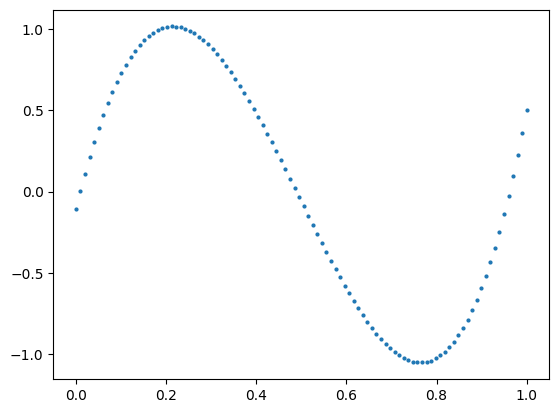

In [346]:
model = LinearRegression() # Model definition
model.fit(X_derived, y) # Fitting the model on the data

# printing the model parameters
coefficients = model.coef_
print("Coefficients of the fitted linear model: {}.".format(coefficients))
intercept = model.intercept_
print("Intercept of the fitted linear model: {}.".format(intercept))

# Visualization
x_range = np.linspace(0, 1, 100)
X_test = poly.fit_transform(x_range.reshape(-1, 1))

predictions = model.predict(X_test)    # doing predictions using the fitted model
print("Predicted model on the first 5 values of x_range: {}.".format(predictions[:5]))

plt.plot(x_range, predictions, 'o', markersize=2);

**Exercise 4:** verify for $M=1,4,11$ that our implementation of the OLS solution of the linear model (`train_lin_mod`) is equivalent to fitting a `LinearRegression` model with scikit-learn. Two potential ways of verifying their equivalence are:
* checking both implementations produce the same parameters and intercept
* (graphically) checking both implementations produce the same predictions on new input data

In [347]:
for M in [1, 4, 11]:
    poly = PolynomialFeatures(degree=M, include_bias=False)
    X_derived = poly.fit_transform(X=X)
    lr = LinearRegression()
    lr.fit(X_derived, y)
    lr_y_hat = lr.predict(X_derived)

    X_derived = polynomial_features(X, M, bias=True)
    f_hat = train_lin_mod(X_derived, y)
    y_hat = f_hat(X_derived)

    assert np.isclose(lr_y_hat, y_hat).all()


## Cross-validation with Scikit-learn

The `model_selection` submodule of scikit-learn contains an implementation of K-fold cross-validation, namely `cross_val_score`. 

In [348]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

**Example:** we perform 6-fold CV using `cross_val_score`. Please observe the following:
* `cross_val_score` does not automatically update its random split of the data in folds. Sometimes this is needed (e.g. when you want to run multiple CVs to get a more precise estimation of the prediction error). For this, one can use the function `KFold`.
* `cross_val_score` does not have the RMSE as a standard error metric. One can use the negative mean-squared error (`neg_mean_squared_error`) and manually compute the RMSE from the result of `cross_val_score`.

In [349]:
M = 10
K = 6

model = LinearRegression()
poly = PolynomialFeatures(degree=M, include_bias=False)
X_derived = poly.fit_transform(X)

# Using KFold to create a new random split of the data in folds.
cv_folds = KFold(n_splits=K, shuffle=True)
print("Integers representing the different splits of the data using the function KFold:")
for a, b in cv_folds.split(X_derived):
    print(a, b)
print("")    

cv_errors_neg_MSE = cross_val_score(model, X_derived, y, cv=cv_folds, scoring='neg_mean_squared_error')
cv_errors_RMSE = np.sqrt(-cv_errors_neg_MSE) # Computing the RMSE from the negative mean-squared error

print("RMSE per fold: {}".format(cv_errors_RMSE))
print("Mean of RMSE over all the folds: {}".format(np.mean(cv_errors_RMSE)))

Integers representing the different splits of the data using the function KFold:
[ 0  2  3  4  5  6  7 10 11 12 13 15 16 17 18 19] [ 1  8  9 14]
[ 0  1  2  3  4  6  8  9 11 12 13 14 15 17 18 19] [ 5  7 10 16]
[ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17] [11 18 19]
[ 1  2  3  5  6  7  8  9 10 11 12 13 14 16 17 18 19] [ 0  4 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 14 15 16 18 19] [12 13 17]
[ 0  1  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19] [2 3 6]

RMSE per fold: [0.51548293 0.09774328 1.12709345 4.97746751 0.19714974 3.71145316]
Mean of RMSE over all the folds: 1.7710650132992514


**Exercise 5:** compare the scikit-learn implementation of 6-fold CV with our implementation (`CV_RMSE`) by performing the cross-validation strategies multiple times (e.g. 100 times) and computing the mean CV error of both strategies. The resulting errors should be very close to each other. Take $M=4.$

In [350]:
%%timeit
M = 4
K = 6
self_implementation = list()
scikit_implementation = list()
X_derived_scikit = PolynomialFeatures(degree=M, include_bias=False).fit_transform(X)

for _ in range(100):
    cv_folds = KFold(n_splits=K, shuffle=True)
    cv_error_neg_mse = cross_val_score(LinearRegression(), X_derived_scikit, y, cv=cv_folds, scoring='neg_mean_squared_error')
    scikit_implementation.append(np.sqrt(-cv_error_neg_mse).mean())

    mean, _ = CV_RMSE(X, y, M, K)
    self_implementation.append(mean)

print(np.mean(self_implementation), np.mean(scikit_implementation))

0.3763711324372752 0.35808467494256546
0.36689191867729115 0.36928985968875855
0.3673732657101582 0.36178804117700564
0.3733743551233908 0.3572133197629168
0.3562759319793928 0.3673348073819834
0.35788208979654307 0.35947025784042486
0.3623508502948409 0.36486928705784977
0.37572077190817305 0.36439584013869736
950 ms ± 39.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Exercise 6:** repeat the previous exercise for $K=N.$ This is leave-one-out cross-validation (LOOCV), where the test set consists of only a single data point and the number of folds is equal to the size of the data set. You should observe two effects:
* the computational time increases due to the large number of folds. In practical situations, this is often a reason to choose low values of K (e.g. $K=5$ or $K=10$).
* the errors of our implementation and of the scikit-learn module are closer to each other. Do you understand why?

In [351]:
%%timeit
M = 4
K = len(X)
self_implementation = list()
scikit_implementation = list()
X_derived_scikit = PolynomialFeatures(degree=M, include_bias=False).fit_transform(X)

for _ in range(100):
    cv_folds = KFold(n_splits=K, shuffle=True)
    cv_error_neg_mse = cross_val_score(LinearRegression(), X_derived_scikit, y, cv=cv_folds, scoring='neg_mean_squared_error')
    scikit_implementation.append(np.sqrt(-cv_error_neg_mse).mean())

    mean, _ = CV_RMSE(X, y, M, K)
    self_implementation.append(mean)

print(np.mean(self_implementation), np.mean(scikit_implementation))

0.2956495544344003 0.2956495544343995
0.2956495544344003 0.2956495544343995
0.29564955443440033 0.2956495544343995
0.2956495544344003 0.29564955443439955
0.2956495544344003 0.29564955443439955
0.29564955443440033 0.29564955443439955
0.29564955443440033 0.29564955443439955
0.29564955443440033 0.29564955443439955
2.94 s ± 75.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Part 4: principal component analysis

## The diabetes dataset

Scikit-learn contains a number of datasets that can be used to test your algorithms or practice your data science skills. Here we use the [diabetes dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset), which contains ten baseline variables (age, sex, body mass index, average blood pressure, and six blood serum measurements) for N = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.

The straightforward linear model of interest contains 11 parameters: one for each of the 10 input features and an intercept $(M = 10 + 1)$. It is often desirable to reduce the dimension of the feature space. For this purpose, we will use Principal Component Analysis.

**Example:** importing all required modules and functions, importing the diabetes dataset, verifying the shape of the data and the names of the features.

In [352]:
from sklearn import datasets
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

dimension_feature_space = X.shape[1]
feature_names = diabetes.feature_names

print(X.shape)
print(y.shape)
print(feature_names)

(442, 10)
(442,)
['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


**Example:** each of the 10 features has been centered and scaled, meaning they have mean 0 and the sum of squares of each column equals 1.

In [353]:
print(np.sum(X, axis=0))
print(np.sum(X**2, axis=0))

[-6.38378239e-16  1.12410081e-15 -9.97119054e-14 -2.14550600e-14
 -6.31439345e-15  1.72327430e-14 -2.66453526e-15 -7.90340016e-15
  4.08562073e-14  5.97482133e-15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Principal components analysis

In this section you will use PCA to reduce the dimension of the feature space, without significantly lowering the generalization performance of the model.

**Example:** use the `svd` method of the numpy.linalg module to perform a reduced/thin singular-value decomposition of the input matrix `X`. Use the ndarray attribute `shape` to verify that the matrices `U` and `V` have the correct dimensions and the number of singular values is correct. (Hint: use the keyword `full_matrices` to get a reduced/thin SVD.)

Furthermore, verify that the SVD is indeed a decomposition of the matrix `X`, i.e. verify that $X = UDV^T.$ (Hint: use the numpy function `allclose`. Note that `svd` returns the tranpose of `V`.)

In [354]:
U, D, V_T = np.linalg.svd(X, full_matrices=False)

V = V_T.T

print("U: ",U.shape, "\tD: ", D.shape, "\tV: ",  V.shape)

np.allclose(X, np.dot(U*D, V_T))

U:  (442, 10) 	D:  (10,) 	V:  (10, 10)


True

**Exercise 7:** run the cell below to verify that the columns of the matrix `U` are orthonormal. Do the same for the columns of `V`.

In [355]:
n = U.shape[1]

print(np.allclose(np.dot(U.T,U), np.eye(n)))
print(np.allclose(np.dot(V.T,V), np.eye(n)))

del n

True
True


**Exercise 8:** run the cell below to inspect the singular values in a screeplot. Purely based on the sizes of the singular values relative to each other, is there a clear distinction between relevant and irrelevant principal components? Answer this question, in your own words, in the markdown cell below the screeplot.

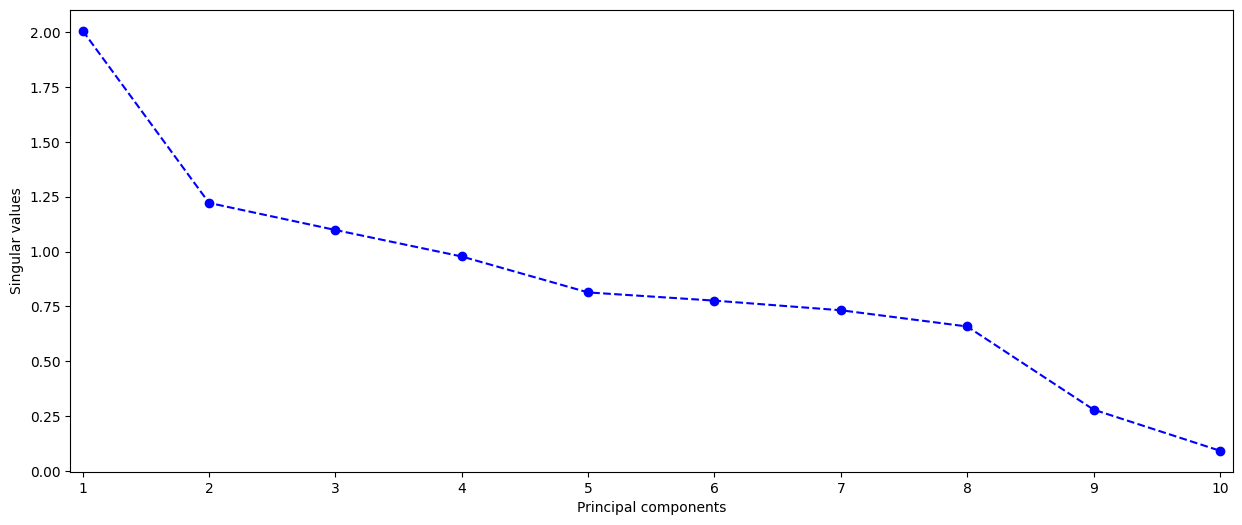

In [356]:
fig8 = plt.figure(8, figsize=(15,6))
ax = fig8.add_subplot(1,1,1)

ax.plot(D, 'bo--')
ax.set_xlim(left=-0.1, right=9.1)
ax.set_xticks(range(0,10))
ax.set_xticklabels(range(1,11))
ax.set_xlabel("Principal components")

ax.set_ylabel("Singular values");

#### ANSWER IN PLAIN TEXT: ####



**Exercise 9:** define a matrix `Z` whose columns are the principal components of `X`. I.e. $z_j = d_j u_j,$ where $z_j$ is the j-th column of `Z`, $u_j$ is the j-th column of `U` and $d_j$ is the j-th singular value. Verify that $$ \text{Var}\,(z_j) = \frac{d_j^2}{N},$$
where $N$ is the number of datapoints.

In [357]:
Z = U * D
np.var(Z, axis=0), D ** 2 / Z.shape[0]

(array([9.10454921e-03, 3.37628886e-03, 2.72843045e-03, 2.16171132e-03,
        1.49814794e-03, 1.36361329e-03, 1.21394944e-03, 9.81181078e-04,
        1.77194625e-04, 1.93681670e-05]),
 array([9.10454921e-03, 3.37628886e-03, 2.72843045e-03, 2.16171132e-03,
        1.49814794e-03, 1.36361329e-03, 1.21394944e-03, 9.81181078e-04,
        1.77194625e-04, 1.93681670e-05]))

**Example:** Run the cell below. By the *explained variance* of a principal component we usually mean the proportion/percentage of the variance along the principal component, relative to the total variance of the features. Here we plotted the cumulative explained variance as a function of the number of principal components taken into account. [Note that this plot is similar to the screeplot above, but with a different quantity plotted on the vertical axis.]

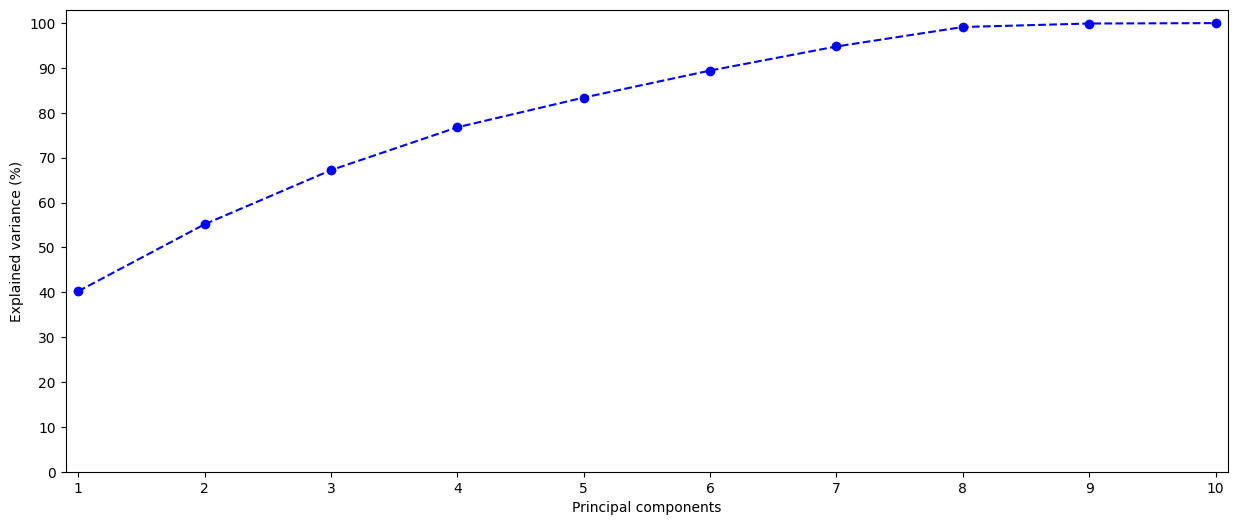

In [358]:
Z = U*D
explained_variance = np.var(Z, axis=0).cumsum()/np.sum(np.var(X, axis=0))

fig8, ax = plt.subplots(figsize=(15,6))

ax.plot(explained_variance, 'bo--')
ax.set_xlim(left=-0.1, right=9.1)
ax.set_xticks(range(0,10))
ax.set_xticklabels(range(1,11))
ax.set_xlabel("Principal components")

ax.set_yticks(np.linspace(0, 1.0, 11))
ax.set_yticklabels(range(0,110,10)) 
ax.set_ylabel("Explained variance (%)");

**Example:** we performed OLS linear regression using only the first principal component of `X` as input variable. We used 20-fold CV to estimate the RMSE and also compute the standard error of the estimate.

(Note: remember that scikit-learn only accepts 2-dimensional arrays as input data. The 2-dimensional array containing only the first principal component can be obtained with `Z[:,0:1]`) 

In [359]:
K = 20

lg = LinearRegression()

cv_folds = KFold(n_splits=K, shuffle=True)

neg_MSE_folds = cross_val_score(lg, Z[:,0:1], y, cv=cv_folds, scoring='neg_mean_squared_error')
RMSE_folds = np.sqrt(-neg_MSE_folds)
RMSE = np.mean(RMSE_folds)
RMSE_std = np.std(RMSE_folds, ddof=1)/np.sqrt(K)

print("RMSE estimate of 20-fold CV: {}".format(RMSE))
print("Standard error of RMSE estimate: {}".format(RMSE_std))

RMSE estimate of 20-fold CV: 63.42969681186217
Standard error of RMSE estimate: 2.437411546518806


**Exercise 10:** perform OLS linear regression using a varying number of principal components of `X` as input variable (ranging from only the first component, to all components). Use 20-fold CV to estimate the RMSE's and also compute the standard error of the estimates. Use the code of the above example as a starting point.

Create a plot of the RMSE's (including errorbars) as a function of the number of principal components taken into account.

How many principal components do you need for a model with a satisfactory performance?

<ErrorbarContainer object of 3 artists>

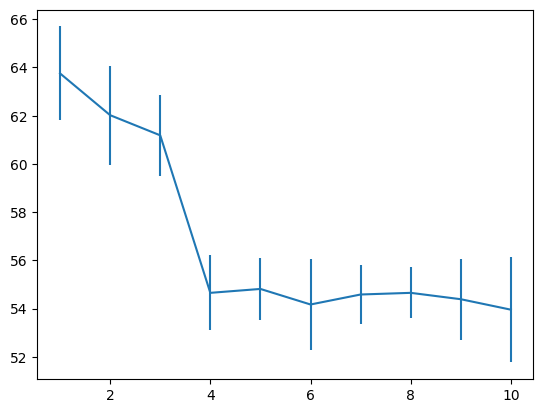

In [360]:
pca_components = np.arange(1,11)
y_rmse_ols = list()
y_rmse_error = list()
for components in pca_components:
    cv_folds = KFold(n_splits=20, shuffle=True)
    neg_mse = cross_val_score(LinearRegression(), Z[:,0:components],y, cv=cv_folds, scoring='neg_mean_squared_error')
    rmse_folds = np.sqrt(-neg_mse)
    y_rmse_ols.append(np.mean(rmse_folds))
    y_rmse_error.append(np.std(rmse_folds, ddof=1)/np.sqrt(K))

plt.errorbar(pca_components, y_rmse_ols, y_rmse_error)

#### ANSWER IN PLAIN TEXT: ####



**Example:** in the cell below, a NumPy array `X_new_observations` containing the data of 7 new, independent patients is loaded. Each datapoint consists of the 10 baseline variables (input features), normalized by the same transformation as was used for the original diabetes dataset. Use the original dataset (`X` and `y`) to train a linear model with the optimal number of principal components, according to the previous exercise. Subsequently, use this model to predict the target variable for the 7 new observations in `X_new_observations`.

In [361]:
X_new_observations = np.genfromtxt("diabetes_new_observations.txt", delimiter=',')     # load new observations

# train the model based on the original dataset
model = LinearRegression()
model.fit(Z[:,:4], y)

# predictions; note that the principal components of the new observations are 
# computed by projecting them on the principal components directions obtained
# from the original (training) dataset
model.predict(X_new_observations @ V[:, :4])

array([191.11580159, 257.47715505, 148.79692183,  62.06895185,
       233.94284112, 117.06643103,  77.2498891 ])

# Part 5: k-nearest neighbors regression

In this part of the computer class, we will use the same data as used in Assignment 1. In the cell below, the data is imported. Both the feature space and the target space are continuous and 1-dimensional. For simplicity, we use 1-dimensional ndarray's for both `x` and `y`.

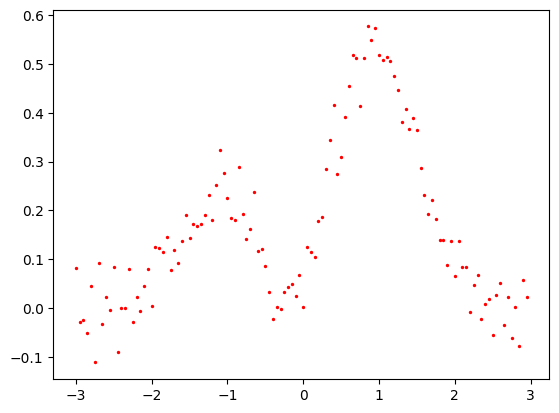

In [362]:
data = np.loadtxt("../week 1/DSM_assignment1_regression_data.csv")
x = data[:,0]
y = data[:,1]

plt.scatter(x, y, s=2, c='red');

**Exercise 11:** write your own code for k-nearest neighbor regression. Based on the data `x` and `y`, the function `kNN_reg` should return a predictor function. This predictor function should, given input `X_new` (also a 1-dimensional ndarray) predict the values of the associated target variable based on k-nearest neighbor regression with uniform weights.

The `#...` represent places where one (**or more than one**) line of code is missing. You are required to fill in the missing code.

In [363]:
def kNN_reg(x, y, k = 2):
    
    def predictor(X_new):
        y_hat = np.array([])
        for x_new in X_new:
            distances = np.abs(x-x_new)
            indices = np.argsort(distances)
            y_hat = np.append(y_hat, np.mean(y[indices[:k]]))        

        
        return y_hat
    
    return predictor


**Example:** run the cell below for different values of $k$ (the number of nearest neighbors taken into account). Make sure to observe the effects of the bias-variance tradeoff.

Text(0, 0.5, 'y')

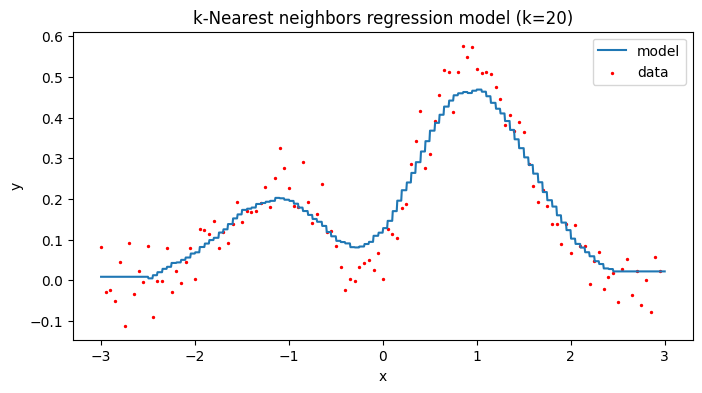

In [364]:
k = 20
predictor = kNN_reg(x, y, k = k)
T = np.linspace(-3,3,1000)
y_ = predictor(T)

fig, ax = plt.subplots(figsize=(8,4))
try:
    ax.plot(T, y_, label="model")
except:
    pass
ax.scatter(x, y, s=2, c='red', label="data");
ax.legend()

ax.set_title("k-Nearest neighbors regression model (k={})".format(k))
ax.set_xlabel("x")
ax.set_ylabel("y")

# Part 6: kernel regression 

**Exercise 12:** repeat the previous exercise, but now for kernel regression proposed by Nadaraya and Watson with a standard normal Gaussian kernel. Instead of `k`, the model hyperparamter is now the bandwidth `bw`. Based on the data `x` and `y`, the function `kern_reg` should return a predictor function. This predictor function should, given input `X_new` (also a 1-dimensional ndarray) predict the values of the associated target variable based on kernel regression regression with bandwidth `bw` and a standard normal Gaussian kernel.

The `#...` represent places where one (**or more than one**) line of code is missing. You are required to fill in the missing code.

In [365]:
def kern_reg(x, y, bw = 0.1):
    
    def predictor(X_new):
        y_hat = np.array([])
        for x_new in X_new:
            weights = np.exp(-0.5*((x-x_new)/bw)**2)
            y_hat = np.append(y_hat, np.sum(weights*y)/np.sum(weights)) 
        
        
        return y_hat
    
    return predictor


**Example:** run the cell below for different values of `bw` (the bandwidth). Make sure to observe the effects of the bias-variance tradeoff.

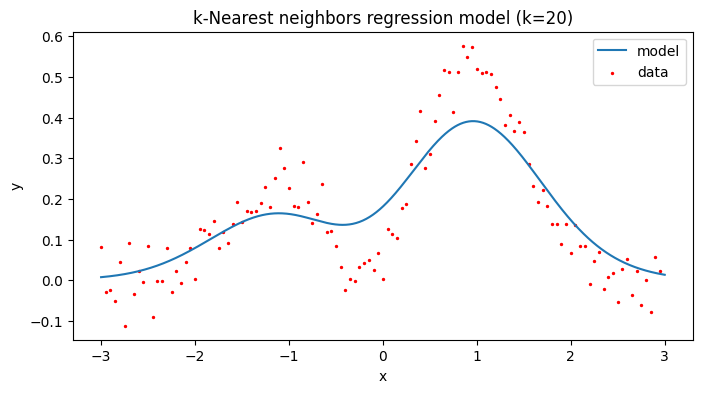

In [366]:
bw = 0.5
predictor = kern_reg(x, y, bw = bw)
T = np.linspace(-3,3,1000)
y_ = predictor(T)

fig, ax = plt.subplots(figsize=(8,4))
try:
    ax.plot(T, y_, label="model")
except:
    pass
ax.scatter(x, y, s=2, c='red', label="data")
ax.legend()

ax.set_title("k-Nearest neighbors regression model (k={})".format(k))
ax.set_xlabel("x")
ax.set_ylabel("y");